In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import joblib

DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

class StockModel:
    def __init__(self, ticker, days_back=500):
        self.ticker = ticker.upper()
        self.days_back = days_back
        self.daily_dir = self.get_daily_subdir()
        self.input_file = os.path.join(self.daily_dir, f"{self.ticker}_data.csv")
        self.indicators_file = os.path.join(self.daily_dir, f"{self.ticker}_data_with_indicators.csv")
        self.scaler_filename = os.path.join(self.daily_dir, f"{self.ticker}_scaler.save")

    def get_daily_subdir(self):
        today = datetime.now().strftime('%Y-%m-%d')
        subdir = os.path.join(DATA_DIR, self.ticker, today)
        os.makedirs(subdir, exist_ok=True)
        return subdir

    def fetch_data(self):
        end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
        start_date = (datetime.now() - timedelta(days=self.days_back)).strftime('%Y-%m-%d')
        stock_data = yf.download(self.ticker, start=start_date, end=end_date)
        if stock_data.empty:
            raise ValueError(f"No data found for ticker {self.ticker}")
        stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        stock_data.reset_index(inplace=True)
        stock_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        stock_data.to_csv(self.input_file, index=False)

    def add_indicators(self):
        if not os.path.exists(self.input_file):
            raise FileNotFoundError(f"File {self.input_file} not found")
        df = pd.read_csv(self.input_file, parse_dates=['Date'])
        df['SMA_10'] = ta.sma(df['Close'], length=10)
        df['SMA_50'] = ta.sma(df['Close'], length=50)
        df['EMA_10'] = ta.ema(df['Close'], length=10)
        df['EMA_50'] = ta.ema(df['Close'], length=50)
        bbands = ta.bbands(df['Close'], length=20)
        df['Bollinger_Upper'] = bbands['BBU_20_2.0']
        df['Bollinger_Middle'] = bbands['BBM_20_2.0']
        df['Bollinger_Lower'] = bbands['BBL_20_2.0']
        df['ATR_14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
        df['RSI_14'] = ta.rsi(df['Close'], length=14)
        macd = ta.macd(df['Close'])
        df['MACD'] = macd['MACD_12_26_9']
        df['MACD_Signal'] = macd['MACDs_12_26_9']
        adx = ta.adx(df['High'], df['Low'], df['Close'], length=14)
        df['ADX_14'] = adx['ADX_14']
        df['DI+_14'] = adx['DMP_14']
        df['DI-_14'] = adx['DMN_14']
        df['CCI_14'] = ta.cci(df['High'], df['Low'], df['Close'], length=14)
        # df.dropna(inplace=True)
        df.to_csv(self.indicators_file, index=False)

    def prepare_training_data(self, seq_len):
        if not os.path.exists(self.indicators_file):
            raise FileNotFoundError(f"File {self.indicators_file} not found")
        df = pd.read_csv(self.indicators_file)
        feature_columns = df.columns.difference(['Date', 'Adj Close'])
        data = df[feature_columns].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)
        joblib.dump(scaler, self.scaler_filename)

        x_data, y_data = [], []
        close_index = list(feature_columns).index('Close')
        for i in range(seq_len, len(scaled_data)):
            x_data.append(scaled_data[i - seq_len:i])
            y_data.append(scaled_data[i, close_index])
        if not x_data:
            raise ValueError(f"Not enough data for seq_len={seq_len}")
        return np.array(x_data), np.array(y_data), feature_columns




In [11]:
#print all x and y datas
print(x_data)
print(y_data)
print(feature_columns)
print(x_train)
print(x_val)
print(y_train)
print(y_val)




[[[0.14683235 0.33337498 0.57665345 ... 0.48306446 0.7210242  0.44776517]
  [0.13424764 0.31343099 0.58001151 ... 0.48532461 0.72024642 0.39666554]
  [0.10095101 0.31873448 0.58589538 ... 0.49345595 0.72111826 0.39080106]
  ...
  [0.08186522 0.18048464 0.55909714 ... 0.48974617 0.55948181 0.24056263]
  [0.10294118 0.1680046  0.55358215 ... 0.50243939 0.56084202 0.33539475]
  [0.09752447 0.192613   0.55478427 ... 0.50965629 0.56053995 0.36986707]]

 [[0.13424764 0.31343099 0.58001151 ... 0.48532461 0.72024642 0.39666554]
  [0.10095101 0.31873448 0.58589538 ... 0.49345595 0.72111826 0.39080106]
  [0.07032334 0.31266198 0.58847039 ... 0.50004417 0.71989371 0.31064174]
  ...
  [0.10294118 0.1680046  0.55358215 ... 0.50243939 0.56084202 0.33539475]
  [0.09752447 0.192613   0.55478427 ... 0.50965629 0.56053995 0.36986707]
  [0.06818696 0.1858191  0.55903929 ... 0.50832098 0.56158904 0.30695237]]

 [[0.10095101 0.31873448 0.58589538 ... 0.49345595 0.72111826 0.39080106]
  [0.07032334 0.312661

In [12]:
def plot_stock_and_predictions_with_future(df, seq_len, y_train, y_val, val_predictions, future_days, future_predictions):
    """
    Sadece son 3 aylık periyot için hisse fiyatlarını, validasyon setindeki model tahminlerini
    ve belirtilen gün sayısı için geleceğe yönelik tahminleri çizer.
    
    Parametreler:
    df: pandas DataFrame - Hisse fiyatlarını ve tarih bilgilerini içerir ('Date', 'Close' sütunları gerekli)
    seq_len: int - Modelin giriş sekans uzunluğu
    y_train: numpy array - Eğitim seti hedef değerleri
    y_val: numpy array - Validasyon seti hedef değerleri
    val_predictions: numpy array - Validasyon seti için model tarafından üretilen ters ölçeklendirilmiş tahminler
    future_days: int - Kaç günlük geleceğe yönelik tahmin çizileceği
    future_predictions: numpy array - Gelecek günlere ait tahmin verileri
    """
    # Tarih sütununu datetime formatına dönüştür
    if df['Date'].dtype == 'object':
        df['Date'] = pd.to_datetime(df['Date'])

    dates = df['Date']
    close_prices = df['Close']

    train_size = len(y_train)
    val_size = len(y_val)

    val_start_idx = seq_len + train_size
    val_end_idx = val_start_idx + val_size

    pred_dates = dates.iloc[val_start_idx:val_end_idx]

    # Son 3 ayın başlangıç tarihini belirle
    last_date = dates.iloc[-1]
    three_months_ago = last_date - pd.DateOffset(months=3)

    # Veri setini son 3 ay ile sınırla
    mask = dates >= three_months_ago
    filtered_dates = dates[mask]
    filtered_close = close_prices[mask]

    # Validasyon seti tahminlerini de son 3 aya sınırla
    val_mask = pred_dates >= three_months_ago
    filtered_pred_dates = pred_dates[val_mask]
    filtered_predictions = val_predictions[val_mask]

    plt.figure(figsize=(12, 6))
    plt.plot(filtered_dates, filtered_close, label='Gerçek Kapanış Fiyatı', color='blue')

    if len(filtered_pred_dates) > 0:
        plt.plot(filtered_pred_dates, filtered_predictions, label='Model Tahmini', linestyle='--', color='red')

    # Gelecek tahminlerini çiz (eğer verilmişse)
    if future_predictions is not None and len(future_predictions) > 0:
        # Gelecek tahminler son bilinen tarihten sonraki günlerden başlayarak çizilecek
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)
        
        # Gelecek tahminler son 3 aylık periyodun dışında kalsa bile göstermek isteyebiliriz.
        # Bu yüzden geleceğe ait tahminleri filtrelemiyoruz.
        plt.plot(future_dates, future_predictions, label=f'{future_days} Günlük Tahmin', linestyle='-.', color='green')

        # X eksenini geleceğe doğru uzatmak için son tarih aralığını yeniden ayarla
        # Eğer son gelecekteki tahminler son 3 ayın sonundan sonrasına düşüyorsa, x-limitleri genişlet:
        end_date = future_dates[-1]
        start_limit = min(filtered_dates.iloc[0], three_months_ago)
        plt.xlim([start_limit, end_date])

    plt.xlabel('Tarih')
    plt.ylabel('Fiyat')
    plt.title('Gerçek vs Model Tahmini (Son 3 Ay) + Gelecek Tahminler')
    plt.legend()
    plt.show()


In [2]:
#NameError: name 'Bidirectional' is not defined
#tf is  not defined
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#batchnormalization
from tensorflow.keras.layers import BatchNormalization
#sequential
from tensorflow.keras.models import Sequential
#tf is  not defined
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#reduce_lr
from tensorflow.keras.callbacks import ReduceLROnPlateau
    

In [3]:
# Örnek data hazırlama
ticker = "AAPL"
days_back = 500
seq_len = 60
epochs = 50
batch_size = 64
learning_rate = 0.001
dropout_rate = 0.2

In [11]:
# Parametre ızgarası
param_grid = {
    "seq_len": [ 60],         # Farklı sekans uzunlukları
    "epochs": [100],         # Eğitim süresini değiştiren epoch sayıları
    "batch_size": [32],       # Farklı batch boyutları
    "learning_rate": [0.001], # Daha geniş öğrenme oranı aralığı
    "dropout_rate": [0.2],  # Çeşitli dropout oranları
    "lstm_units": [64 ],     # LSTM katmanlarındaki nöron sayısını değiştirmek
    "dense_units": [64]       # Dense katman sayısını ve birim sayısını ayarlamak için
}

best_score = float('inf')
best_params = None
best_inv_val_predictions = None
best_inv_future_predictions = None

ticker = "AAPL"
days_back = 500

# Ana döngüde hiperparametre kombinasyonlarını dene
for seq_len in param_grid['seq_len']:
    for epochs in param_grid['epochs']:
        for batch_size in param_grid['batch_size']:
            for learning_rate in param_grid['learning_rate']:
                for dropout_rate in param_grid['dropout_rate']:
                    # Veri hazırlığı
                    stock_model = StockModel(ticker, days_back)
                    stock_model.fetch_data()
                    stock_model.add_indicators()
#                     x_data, y_data, feature_columns = stock_model.prepare_training_data(seq_len)
#                     x_train, x_val, y_train, y_val = train_test_split(
#                         x_data, y_data, test_size=0.1, shuffle=False
#                     )

#                     # Modeli oluştur
#                     model = Sequential([
#                         Bidirectional(LSTM(128, return_sequences=True, input_shape=(seq_len, len(feature_columns)))),
#                         Dropout(dropout_rate),
#                         Bidirectional(LSTM(64, return_sequences=True)),
#                         Dropout(dropout_rate),
#                         Bidirectional(LSTM(32)),
#                         Dropout(dropout_rate),
#                         Dense(64, activation='relu'),
#                         Dense(32, activation='relu'),
#                         Dense(1)
#                     ])

#                     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#                     model.compile(optimizer=optimizer, loss='mean_squared_error')

#                     early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#                     checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=0)

#                     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)

#                     history = model.fit(
#                         x_train, y_train,
#                         epochs=epochs,
#                         batch_size=batch_size,
#                         validation_data=(x_val, y_val),
#                         callbacks=[early_stop, checkpoint, reduce_lr],
#                         verbose=0
#                     )

#                     # Val tahminleri
#                     val_predictions = model.predict(x_val, verbose=0)

#                     # Tahminleri ters ölçeklendir
#                     scaler = joblib.load(stock_model.scaler_filename)
#                     feature_columns_list = list(feature_columns)
#                     close_index = feature_columns_list.index('Close')

#                     data = pd.read_csv(stock_model.indicators_file)[feature_columns].values
#                     scaled_data = scaler.transform(data)

#                     val_pred_array = np.zeros((len(val_predictions), scaled_data.shape[1]))
#                     val_pred_array[:, close_index] = val_predictions.flatten()
#                     inv_val_predictions = scaler.inverse_transform(val_pred_array)[:, close_index]

#                     rmse = np.sqrt(mean_squared_error(y_val, inv_val_predictions))

#                     # Gelecek 15 günlük tahmin
#                     future_days = 15
#                     last_seq = scaled_data[-seq_len:, :]

#                     future_predictions = []
#                     current_seq = last_seq.copy()

#                     for i in range(future_days):
#                         pred = model.predict(current_seq[np.newaxis, ...], verbose=0)[0, 0]
#                         next_row = current_seq[-1].copy()
#                         next_row[close_index] = pred
#                         current_seq = np.vstack([current_seq[1:], next_row])
#                         future_predictions.append(pred)

#                     pred_array = np.zeros((future_days, scaled_data.shape[1]))
#                     pred_array[:, close_index] = future_predictions
#                     inv_future_predictions = scaler.inverse_transform(pred_array)[:, close_index]

#                     # Parametreleri yazdır
#                     print(f"Parametreler: seq_len={seq_len}, epochs={epochs}, batch_size={batch_size}, learning_rate={learning_rate}, dropout_rate={dropout_rate}")
#                     print(f"RMSE: {rmse}")

#                     # Grafik çizimi
#                     plot_stock_and_predictions_with_future(
#                         df=pd.read_csv(stock_model.indicators_file),
#                         seq_len=seq_len,
#                         y_train=y_train,
#                         y_val=y_val,
#                         val_predictions=inv_val_predictions,
#                         future_days=future_days,
#                         future_predictions=inv_future_predictions
#                     )

#                     # En iyi modeli güncelle
#                     if rmse < best_score:
#                         best_score = rmse
#                         best_params = (seq_len, epochs, batch_size, learning_rate, dropout_rate)
#                         best_inv_val_predictions = inv_val_predictions
#                         best_inv_future_predictions = inv_future_predictions

# # En iyi parametreleri yazdır
# print("En iyi parametreler:")
# print("seq_len:", best_params[0])
# print("epochs:", best_params[1])
# print("batch_size:", best_params[2])
# print("learning_rate:", best_params[3])
# print("dropout_rate:", best_params[4])
# print("En iyi RMSE:", best_score)


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Parameters: seq_len=60, n_estimators=100, max_depth=3, learning_rate=0.001, subsample=0.8, colsample_bytree=0.8
RMSE: 207.35054896814214


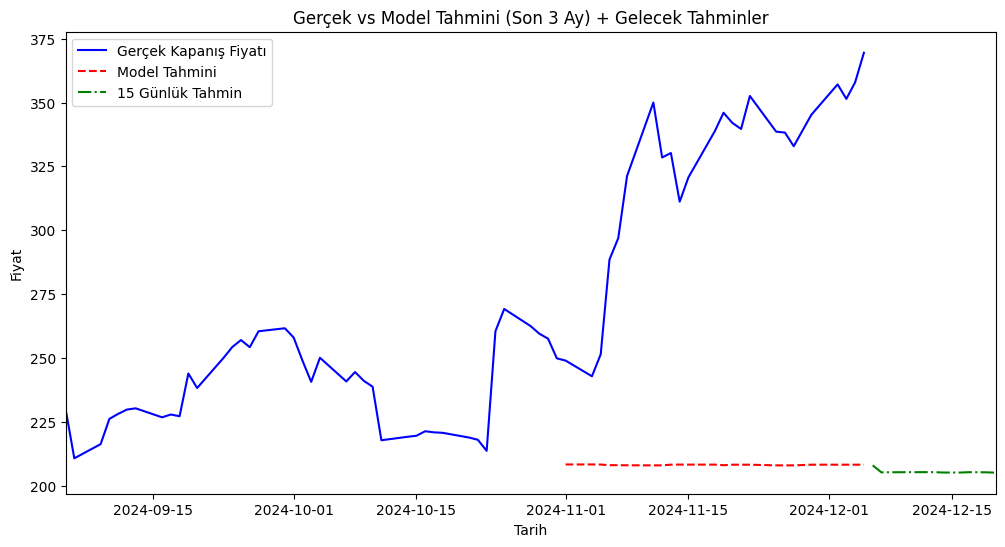

Best parameters:
seq_len: 60
n_estimators: 100
max_depth: 3
learning_rate: 0.001
subsample: 0.8
colsample_bytree: 0.8
Best RMSE: 207.35054896814214


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import joblib

# Hyperparameter grid
param_grid = {
    "seq_len": [60],         # Sequence lengths
    "epochs": [100],         # Number of epochs
    "learning_rate": [0.001], # Learning rates
    "n_estimators": [100],    # Number of estimators (boosting rounds)
    "max_depth": [3],         # Maximum tree depth
    "subsample": [0.8],       # Subsample ratio
    "colsample_bytree": [0.8] # Ratio of features used per tree
}

# Data preparation
stock_model = StockModel(ticker, days_back)
stock_model.fetch_data()
stock_model.add_indicators()
x_data, y_data, feature_columns = stock_model.prepare_training_data(param_grid['seq_len'][0])
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.1, shuffle=False
)
x_train = x_train.reshape(x_train.shape[0], -1)  # Reshape for XGBoost
x_val = x_val.reshape(x_val.shape[0], -1)

best_score = float('inf')
best_params = None
best_inv_val_predictions = None
best_inv_future_predictions = None

# Hyperparameter search
for seq_len in param_grid['seq_len']:
    for epochs in param_grid['epochs']:
        for learning_rate in param_grid['learning_rate']:
            for n_estimators in param_grid['n_estimators']:
                for max_depth in param_grid['max_depth']:
                    for subsample in param_grid['subsample']:
                        for colsample_bytree in param_grid['colsample_bytree']:
                            # Build the model
                            model = XGBRegressor(
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                verbosity=0
                            )

                            # Train the model
                            model.fit(
                                x_train,
                                y_train,
                                eval_set=[(x_val, y_val)],
                                verbose=False,
                            )

                            # Predict on validation set
                            val_predictions = model.predict(x_val)

                            # Reverse scaling
                            scaler = joblib.load(stock_model.scaler_filename)
                            feature_columns_list = list(feature_columns)
                            close_index = feature_columns_list.index('Close')

                            data = pd.read_csv(stock_model.indicators_file)[feature_columns].values
                            scaled_data = scaler.transform(data)

                            val_pred_array = np.zeros((len(val_predictions), scaled_data.shape[1]))
                            val_pred_array[:, close_index] = val_predictions
                            inv_val_predictions = scaler.inverse_transform(val_pred_array)[:, close_index]

                            # Calculate RMSE
                            rmse = np.sqrt(mean_squared_error(y_val, inv_val_predictions))

                            # Generate future predictions
                            future_days = 15
                            last_seq = scaled_data[-seq_len:, :]

                            future_predictions = []
                            current_seq = last_seq.copy()

                            for i in range(future_days):
                                current_seq_flat = current_seq.reshape(1, -1)
                                pred = model.predict(current_seq_flat)[0]
                                next_row = current_seq[-1].copy()
                                next_row[close_index] = pred
                                current_seq = np.vstack([current_seq[1:], next_row])
                                future_predictions.append(pred)

                            pred_array = np.zeros((future_days, scaled_data.shape[1]))
                            pred_array[:, close_index] = future_predictions
                            inv_future_predictions = scaler.inverse_transform(pred_array)[:, close_index]

                            # Print parameters and RMSE
                            print(f"Parameters: seq_len={seq_len}, n_estimators={n_estimators}, max_depth={max_depth}, "
                                  f"learning_rate={learning_rate}, subsample={subsample}, colsample_bytree={colsample_bytree}")
                            print(f"RMSE: {rmse}")

                            # Plot results
                            plot_stock_and_predictions_with_future(
                                df=pd.read_csv(stock_model.indicators_file),
                                seq_len=seq_len,
                                y_train=y_train,
                                y_val=y_val,
                                val_predictions=inv_val_predictions,
                                future_days=future_days,
                                future_predictions=inv_future_predictions
                            )

                            # Update best model
                            if rmse < best_score:
                                best_score = rmse
                                best_params = (seq_len, n_estimators, max_depth, learning_rate, subsample, colsample_bytree)
                                best_inv_val_predictions = inv_val_predictions
                                best_inv_future_predictions = inv_future_predictions

# Print best parameters
print("Best parameters:")
print("seq_len:", best_params[0])
print("n_estimators:", best_params[1])
print("max_depth:", best_params[2])
print("learning_rate:", best_params[3])
print("subsample:", best_params[4])
print("colsample_bytree:", best_params[5])
print("Best RMSE:", best_score)


[*********************100%***********************]  1 of 1 completed


Parameters: seq_len=30, n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6
RMSE: 204.75979804444972


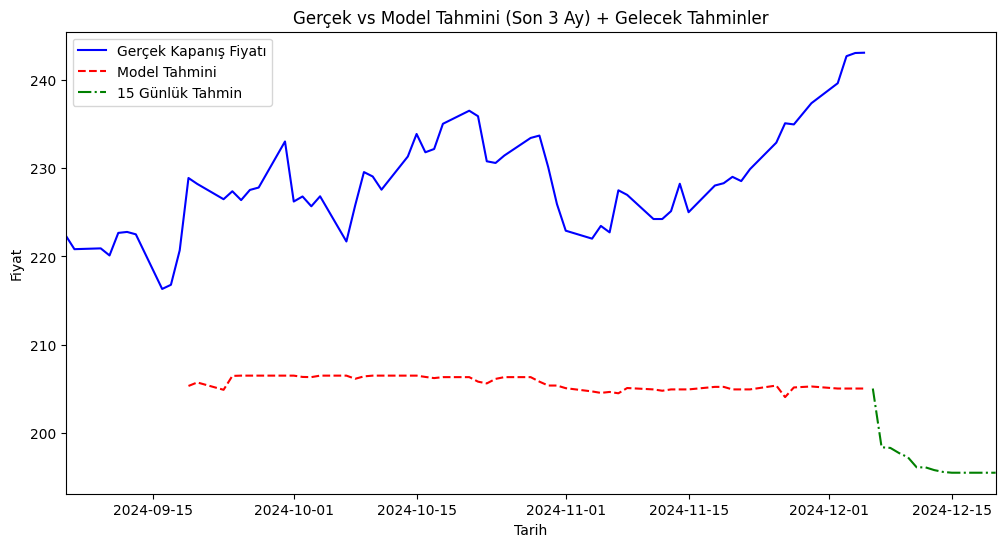

Parameters: seq_len=30, n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8
RMSE: 204.8381613225646


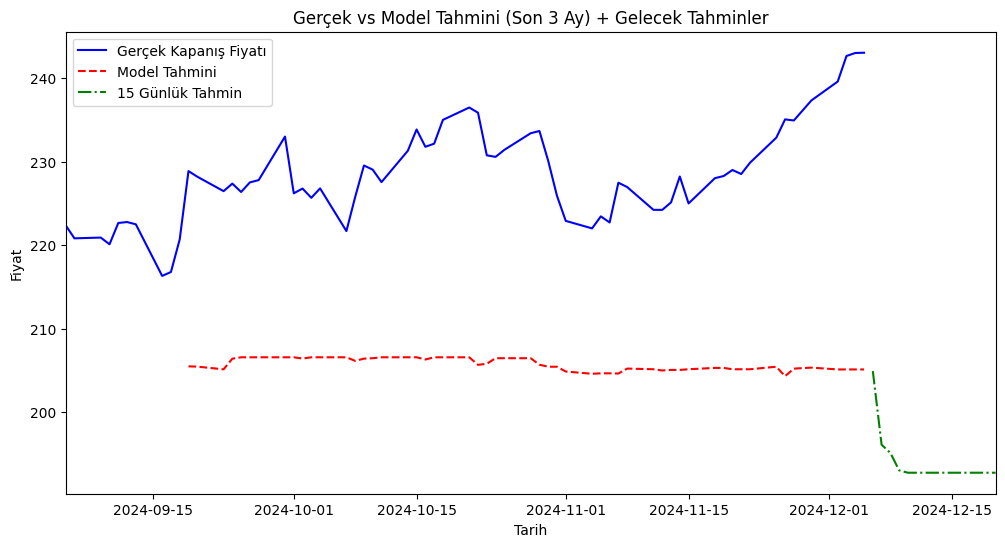

Parameters: seq_len=30, n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0
RMSE: 204.80242433932128


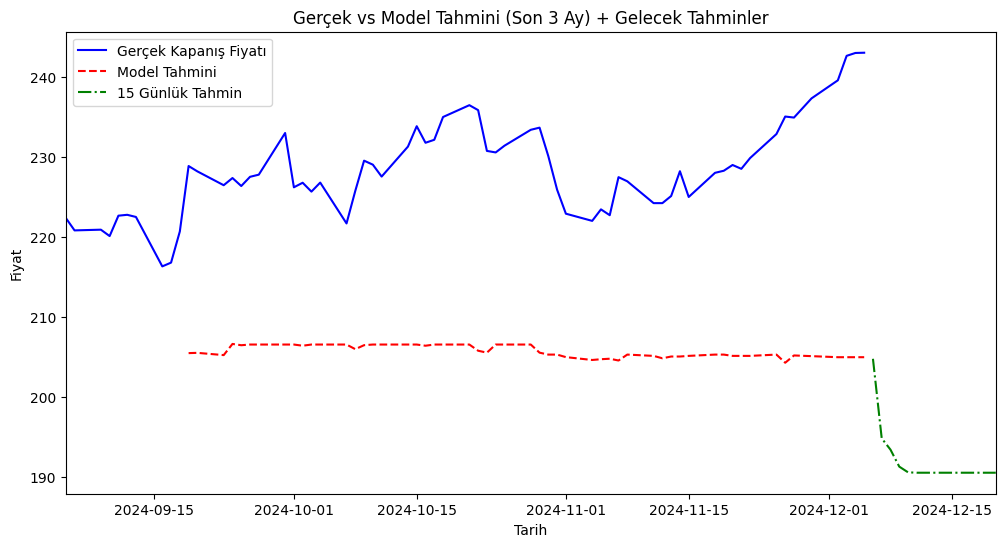

Parameters: seq_len=30, n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6
RMSE: 205.62368255641917


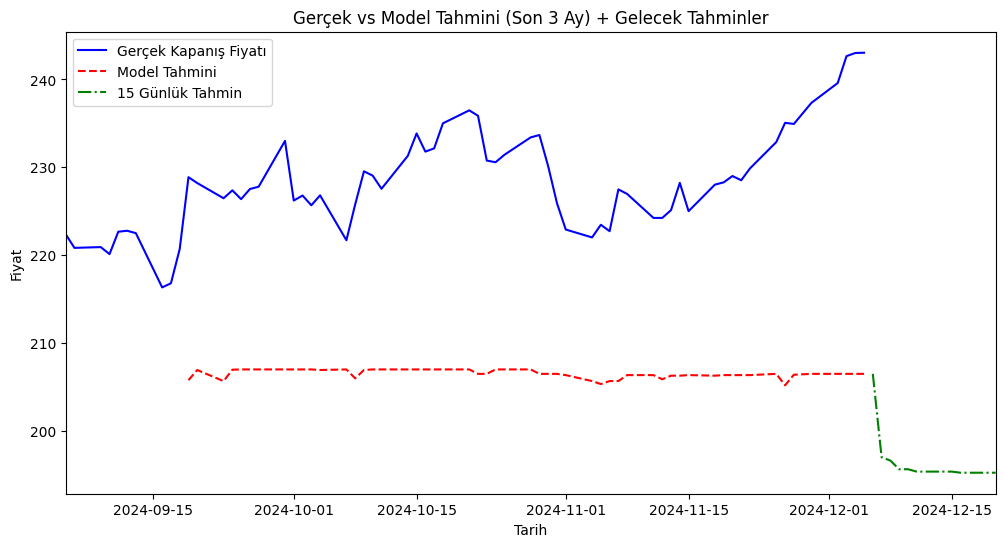

Parameters: seq_len=30, n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8
RMSE: 205.6793486569447


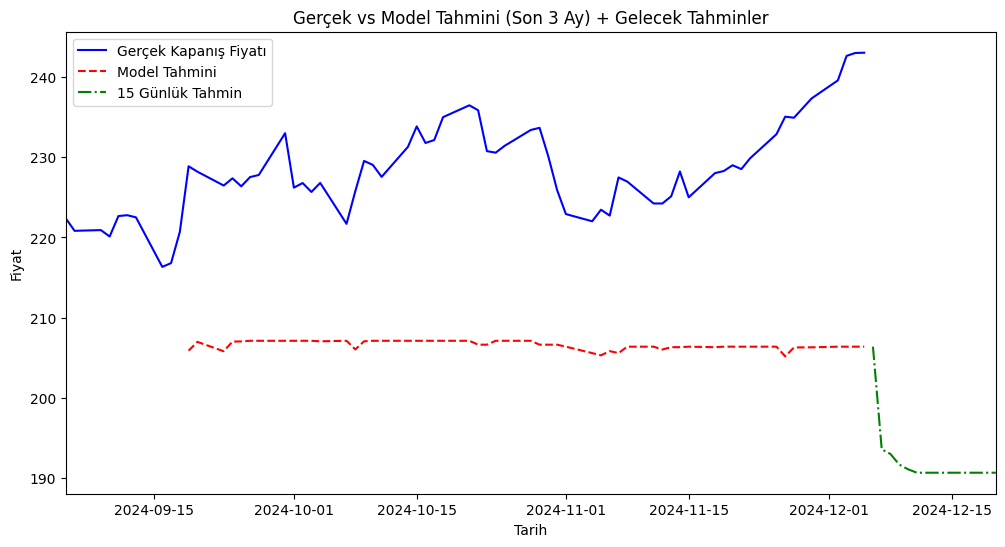

Parameters: seq_len=30, n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0
RMSE: 205.63547447472752


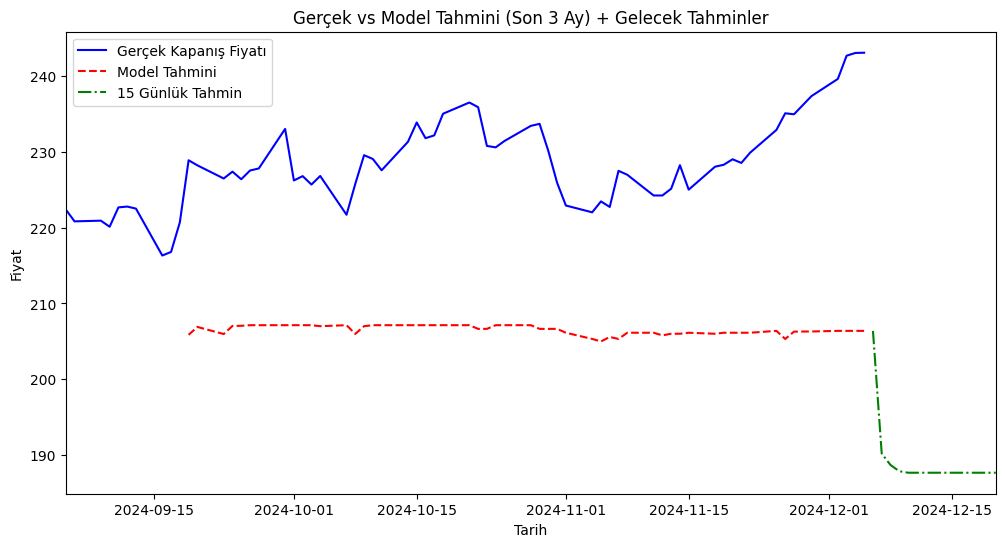

Parameters: seq_len=30, n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.6
RMSE: 206.0672047876508


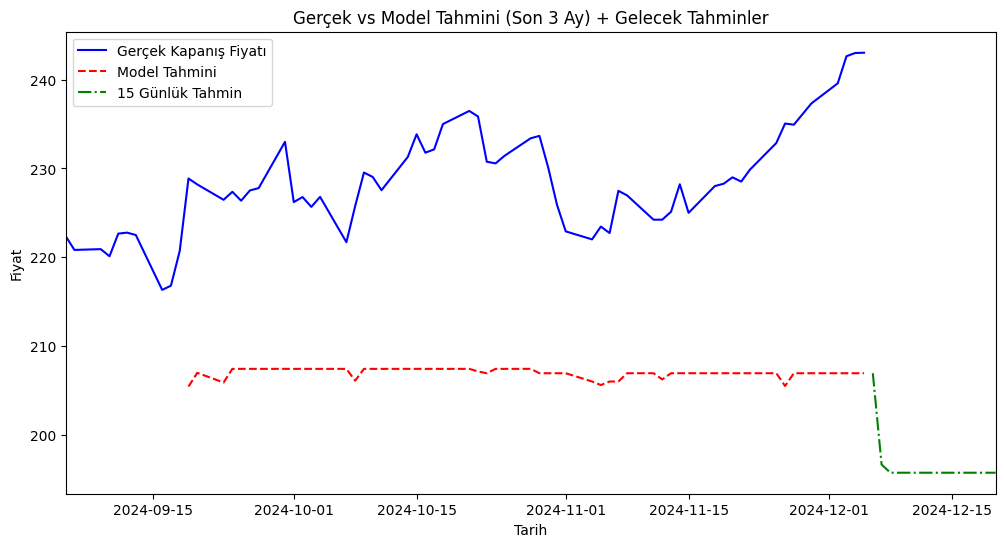

Parameters: seq_len=30, n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8
RMSE: 206.21715658202714


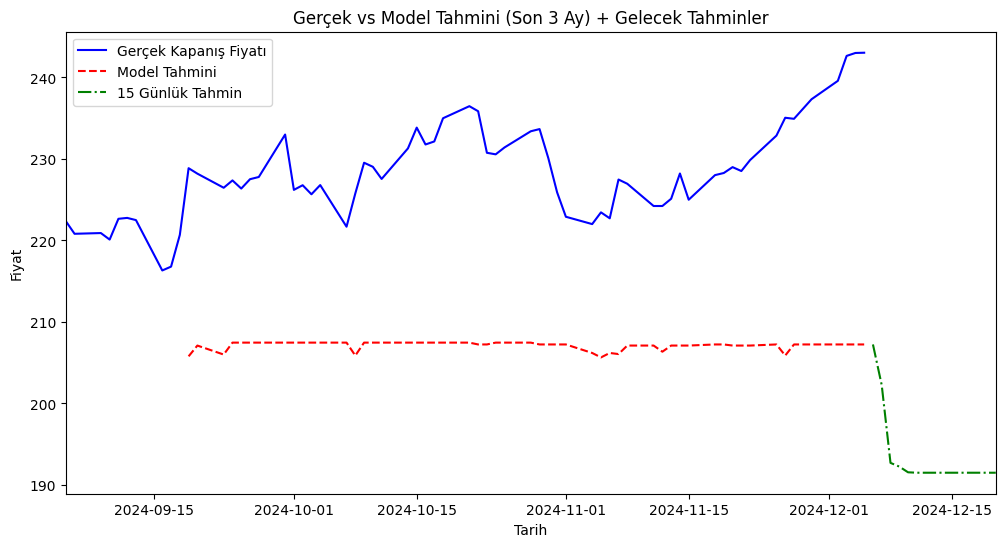

Parameters: seq_len=30, n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0
RMSE: 206.29316929014882


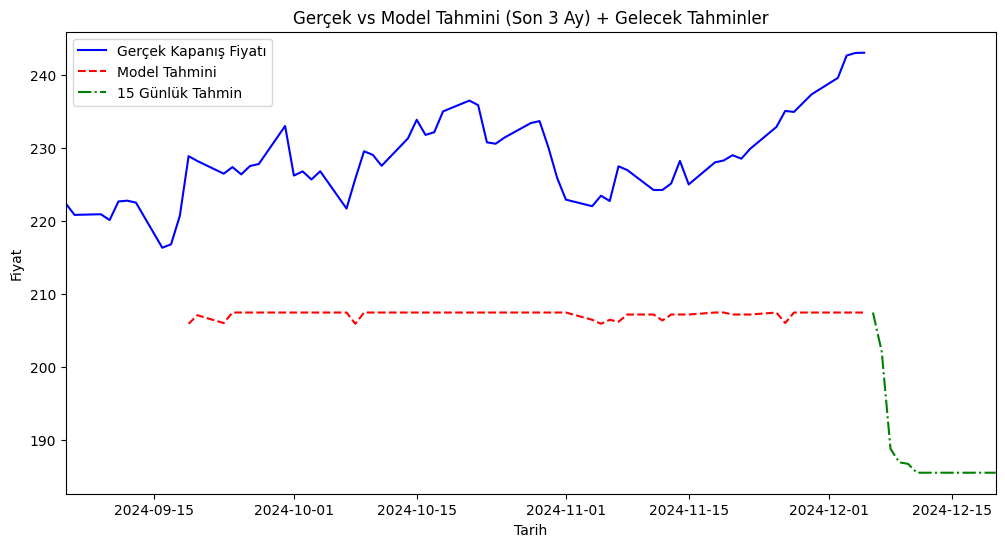

Parameters: seq_len=30, n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6
RMSE: 204.63422958566932


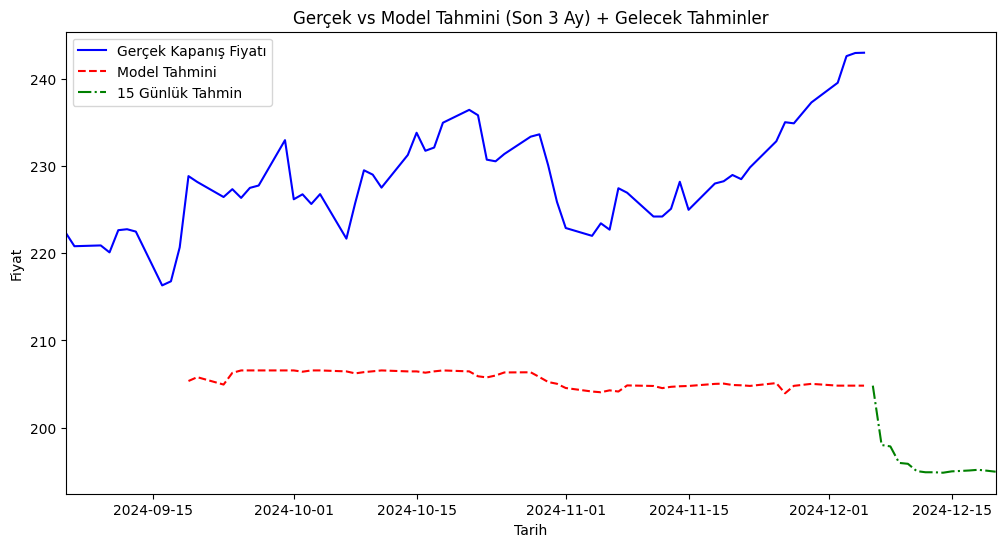

Parameters: seq_len=30, n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8
RMSE: 204.85342753231868


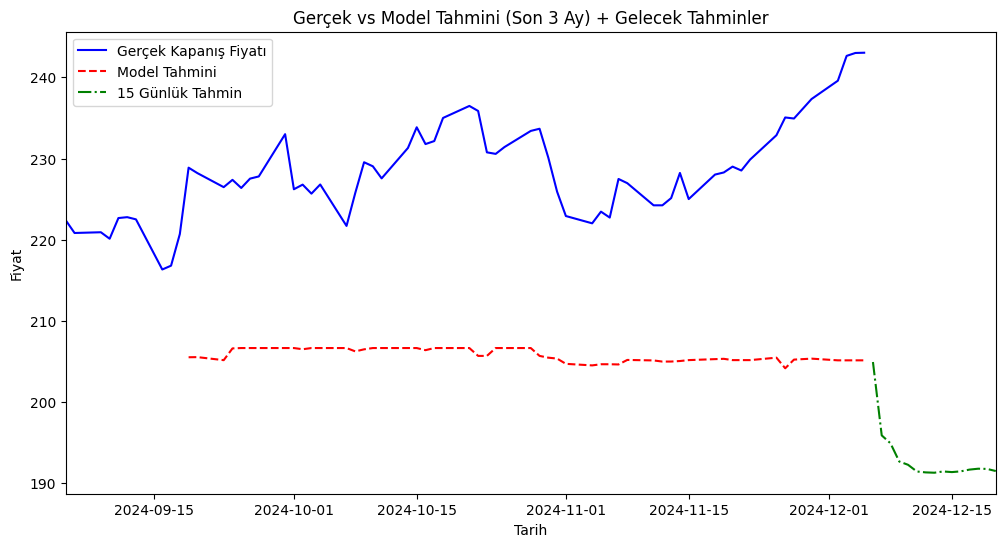

Parameters: seq_len=30, n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0
RMSE: 204.6502706208914


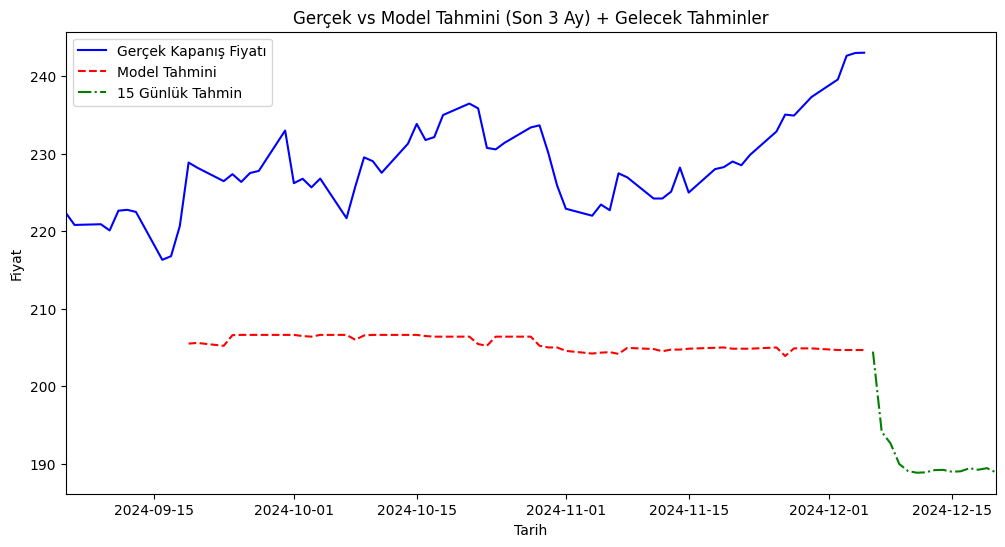

Parameters: seq_len=30, n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6
RMSE: 205.56099624254003


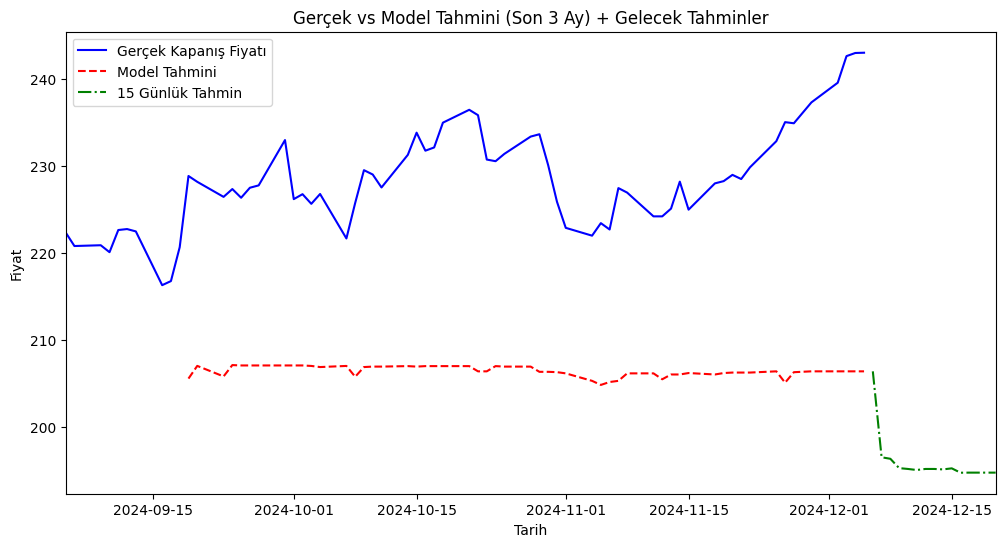

KeyboardInterrupt: 

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import joblib

# Define a function for inverse scaling
def inverse_scale_predictions(predictions, scaler, feature_columns, close_index):
    pred_array = np.zeros((len(predictions), len(feature_columns)))
    pred_array[:, close_index] = predictions
    return scaler.inverse_transform(pred_array)[:, close_index]

# Define a function for future prediction generation
def generate_future_predictions(model, last_seq, seq_len, future_days, close_index, feature_columns, scaler):
    future_predictions = []
    current_seq = last_seq.copy()

    for _ in range(future_days):
        current_seq_flat = current_seq.reshape(1, -1)
        pred = model.predict(current_seq_flat)[0]
        next_row = current_seq[-1].copy()
        next_row[close_index] = pred
        current_seq = np.vstack([current_seq[1:], next_row])
        future_predictions.append(pred)

    pred_array = np.zeros((future_days, len(feature_columns)))
    pred_array[:, close_index] = future_predictions
    return scaler.inverse_transform(pred_array)[:, close_index]
# Örnek data hazırlama
ticker = "AAPL"
days_back = 2000
seq_len = 60
epochs = 50
batch_size = 64
learning_rate = 0.001
dropout_rate = 0.2
# Hyperparameter grid
param_grid = {
    "seq_len": [30, 60, 90],             # Sequence lengths
    "epochs": [50, 100, 200],           # Number of epochs
    "learning_rate": [0.01, 0.05, 0.1], # Learning rates
    "n_estimators": [100, 200, 300],    # Number of estimators (boosting rounds)
    "max_depth": [3, 5, 7],             # Maximum tree depth
    "subsample": [0.6, 0.8, 1.0],       # Subsample ratio
    "colsample_bytree": [0.6, 0.8, 1.0] # Ratio of features used per tree
}


# Data preparation
stock_model = StockModel(ticker, days_back)
stock_model.fetch_data()
stock_model.add_indicators()
x_data, y_data, feature_columns = stock_model.prepare_training_data(param_grid['seq_len'][0])
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.1, shuffle=False
)
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)

best_score = float('inf')
best_params = None
best_inv_val_predictions = None
best_inv_future_predictions = None

# Extract close column index for scaling purposes
scaler = joblib.load(stock_model.scaler_filename)
feature_columns_list = list(feature_columns)
close_index = feature_columns_list.index('Close')
data = pd.read_csv(stock_model.indicators_file)[feature_columns].values
scaled_data = scaler.transform(data)

# Hyperparameter search
for seq_len in param_grid['seq_len']:
    for epochs in param_grid['epochs']:
        for learning_rate in param_grid['learning_rate']:
            for n_estimators in param_grid['n_estimators']:
                for max_depth in param_grid['max_depth']:
                    for subsample in param_grid['subsample']:
                        for colsample_bytree in param_grid['colsample_bytree']:
                            # Build and train the model
                            model = XGBRegressor(
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                verbosity=0
                            )
                            model.fit(
                                x_train,
                                y_train,
                                eval_set=[(x_val, y_val)],
                                verbose=False
                            )

                            # Predict on validation data
                            val_predictions = model.predict(x_val)
                            inv_val_predictions = inverse_scale_predictions(val_predictions, scaler, feature_columns, close_index)
                            rmse = np.sqrt(mean_squared_error(y_val, inv_val_predictions))

                            # Predict future values
                            future_days = 15
                            last_seq = scaled_data[-seq_len:, :]
                            inv_future_predictions = generate_future_predictions(
                                model, last_seq, seq_len, future_days, close_index, feature_columns, scaler
                            )

                            # Log results
                            print(f"Parameters: seq_len={seq_len}, n_estimators={n_estimators}, max_depth={max_depth}, "
                                  f"learning_rate={learning_rate}, subsample={subsample}, colsample_bytree={colsample_bytree}")
                            print(f"RMSE: {rmse}")

                            # Plot results
                            plot_stock_and_predictions_with_future(
                                df=pd.read_csv(stock_model.indicators_file),
                                seq_len=seq_len,
                                y_train=y_train,
                                y_val=y_val,
                                val_predictions=inv_val_predictions,
                                future_days=future_days,
                                future_predictions=inv_future_predictions
                            )

                            # Update the best model
                            if rmse < best_score:
                                best_score = rmse
                                best_params = (seq_len, n_estimators, max_depth, learning_rate, subsample, colsample_bytree)
                                best_inv_val_predictions = inv_val_predictions
                                best_inv_future_predictions = inv_future_predictions

# Print best parameters
print("Best parameters:")
print("seq_len:", best_params[0])
print("n_estimators:", best_params[1])
print("max_depth:", best_params[2])
print("learning_rate:", best_params[3])
print("subsample:", best_params[4])
print("colsample_bytree:", best_params[5])
print("Best RMSE:", best_score)
